In [1]:
import datetime as dt
import os
import sys
sys.path.append(os.pardir)

import numpy as np

from coropy import simulate

In [2]:
# total data
confirmed_cases = np.loadtxt('../data/confirmed_cases.dat')
recovered_cases = np.loadtxt('../data/recovered_cases.dat')
death_cases = np.loadtxt('../data/death_cases.dat')
removed_cases = recovered_cases + death_cases
active_cases = confirmed_cases - removed_cases

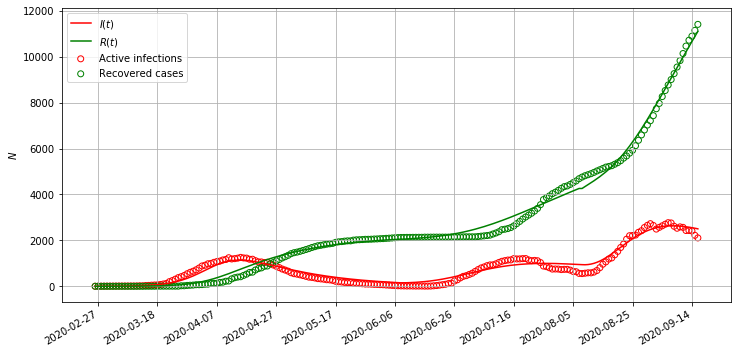

In [3]:
(S, E, I, R) = simulate.seir_multiple_waves(
    active_cases=active_cases, 
    removed_cases=recovered_cases,
    first_wave_eff_population=2200,
    eff_dates=[dt.datetime(2020, 2, 26),
               dt.datetime(2020, 6, 9),
               dt.datetime(2020, 8, 8)],
    plot_sim=True)

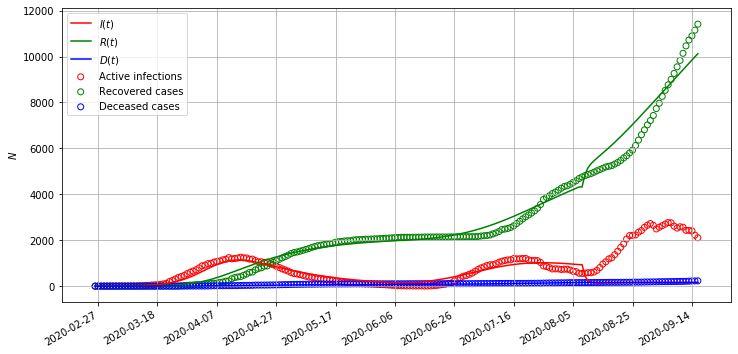

In [4]:
(S, E, I, R, D) = simulate.seird_multiple_waves(
    active_cases=active_cases, 
    recovered_cases=recovered_cases,
    death_cases=death_cases,
    first_wave_eff_population=2200,
    eff_dates=[dt.datetime(2020, 2, 26),
               dt.datetime(2020, 6, 9),
               dt.datetime(2020, 8, 8)],
    plot_sim=True)